In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
import os
from datetime import datetime
from ratinabox.Environment import Environment

from tqdm import tqdm

from src.models import *
from src.data_generation import *

Parameters

In [13]:
# Trajectory parameters
n_traj = 100000                 # no. of trajectories per env
timesteps = 250                 # no. of timesteps
rayleigh_scale = 0.05
vonmises_kappa = 4 * np.pi

# Training parameters
bs = 32                         # batch size
epochs = 10                  # no. of epochs
lr = 1e-4                       # learning rate

# Model parameters
n_in = 2                        # Cartesian coordinates, no context
n_out = 250                     # no. of spatial representations
initial_state_size = 32         # size of initial state
scale = 0.2                     # scale of gaussian

Load dataset

In [15]:
# Load dataset and environment
ident = 'square-large'
folder = 'random_mixed'
folder = 'square-large'

env = torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', folder, f'env_{ident}.pt'))
dataset = torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', folder, f'dataset_{ident}.pt'))

Train model

In [17]:
device = 'cpu' # 'mps', 'cpu'

# Init model and optimizer
model = StackedRecurrentSpaceNet(n_in, n_out, initial_state_size=initial_state_size, corr_across_space=False, num_layers=2, scale=scale, device=device, init_weights='identity')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Create dataloader
data = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_history = []
for e in range(epochs):

    progress = tqdm(data)
    for i, (r_batch, v_batch) in enumerate(progress):

        r_batch = r_batch.to(device)
        v_batch = v_batch.to(device)

        loss = model.train_step(x=v_batch, y=r_batch[:, 1:], optimizer=optimizer)
        # loss = model.train_step(x=(v_batch, r_batch[:, 0]), y=r_batch[:, 1:], optimizer=optimizer)

        if i % 10 == 0:
            loss_history.append(loss)
            progress.set_description(f"loss: {loss:>7f}")

loss: 0.016547: 100%|██████████| 3125/3125 [04:19<00:00, 12.06it/s]


Text(0, 0.5, 'Train Loss')

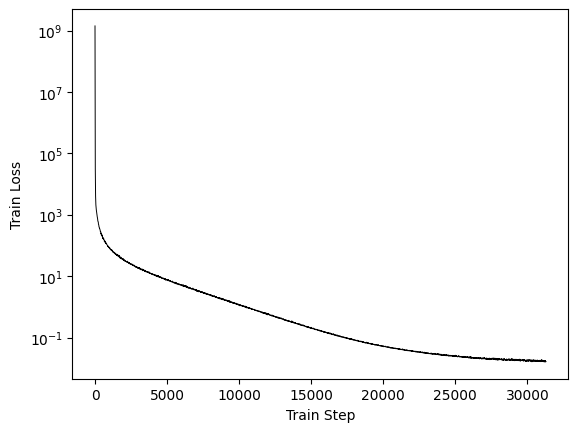

In [18]:
plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

Get spatial representations and visualize

In [2]:
# Generate test data
# r_test, v_test = env.generate_random_trajectories(n_traj=100, n_steps=timesteps)

r_test, v_test = torch.utils.data.Subset(dataset, np.arange(100)).dataset.tensors



# Get spatial representation
# outputs, hidden = model.get_all_outputs(v_test, model.initial_state(v_test.shape[0]))

NameError: name 'torch' is not defined

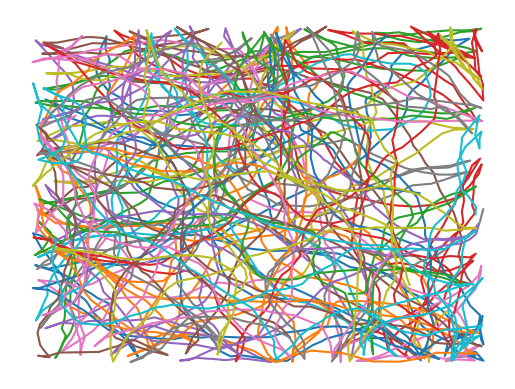

In [20]:
plt.plot(*r_test.detach().numpy()[:20].T)
plt.axis('off')
plt.show()

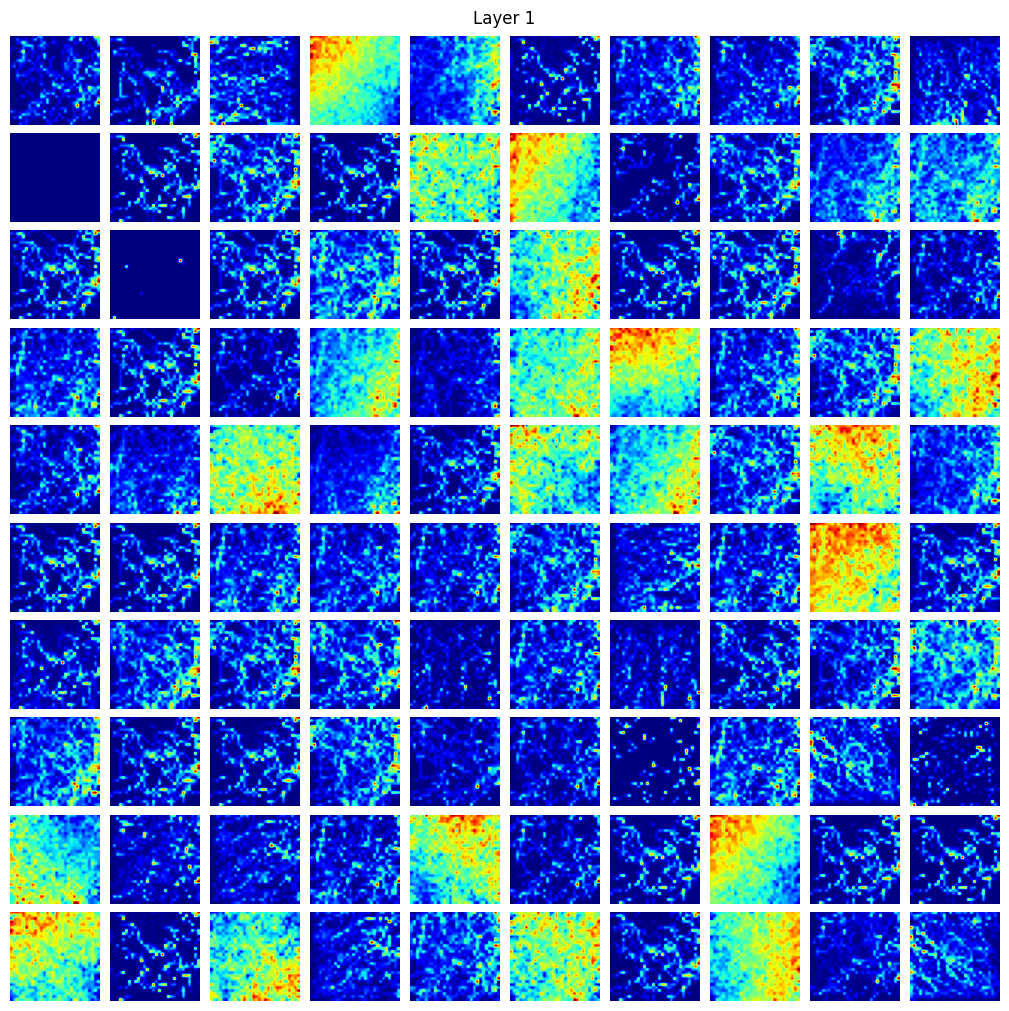

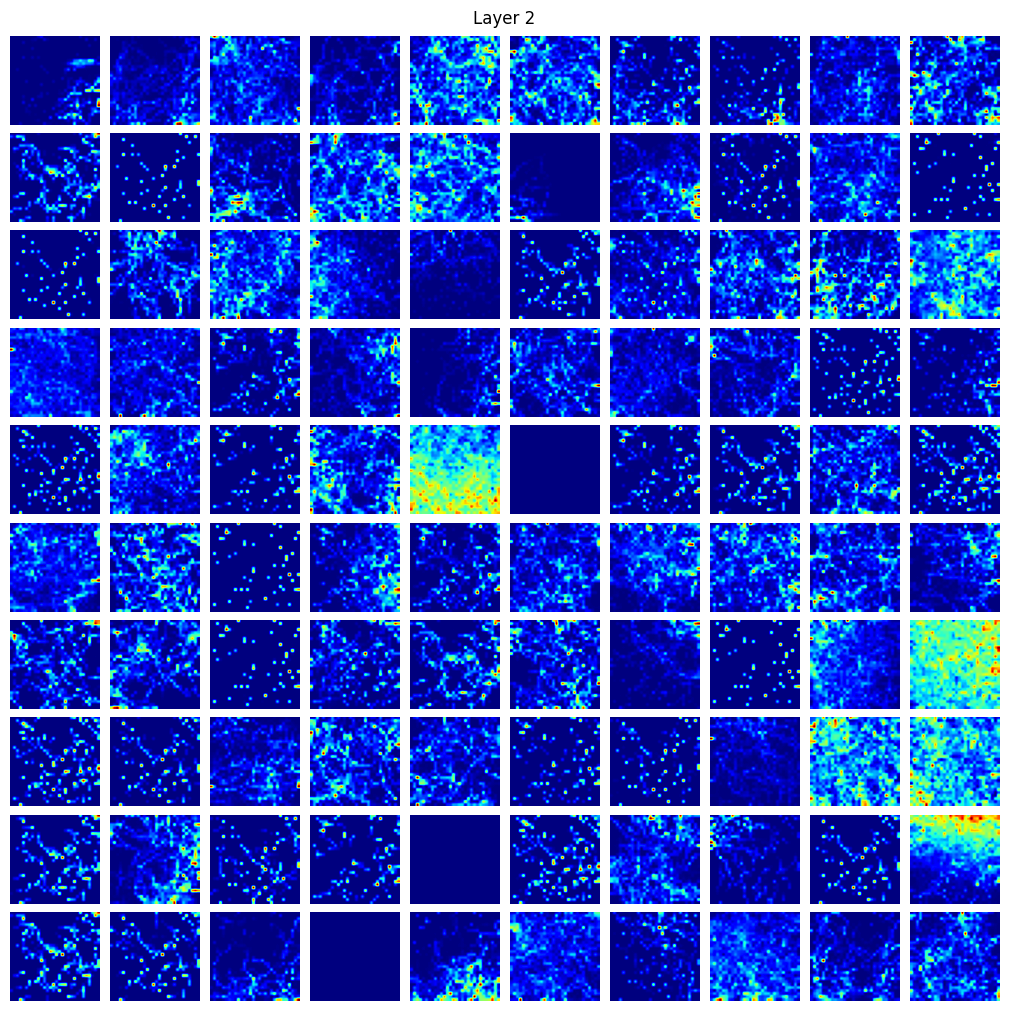

In [21]:
n_show = 10

for n, p in enumerate(outputs):
    fig, ax = plt.subplots(n_show, n_show, figsize=(10, 10), constrained_layout=True)

    # Prepare stuff
    r0 = r_test[:,1:].detach().numpy()
    ps = p.reshape(-1, n_out)
    rs = r0.reshape(-1, 2)

    for i in range(n_show**2):
        hist, _, _, _ = stats.binned_statistic_2d(values=ps[:, i], x=rs[:,0], y=rs[:,1], bins=30)
        ax[i//n_show, i%n_show].imshow(hist.T, origin="lower", cmap="jet")
        ax[i//n_show, i%n_show].axis("off")

    fig.suptitle(f'Layer {n + 1}')

    plt.show()

Test live generation of trajectories

In [ ]:
env = PolygonEnvironment()
env.polygon

In [ ]:
device = 'cpu' # 'mps', 'cpu'

# Init model and optimizer
model = RecurrentSpaceNet(n_in, n_out, initial_state_size=initial_state_size, corr_across_space=False, num_layers=1, scale=scale, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history = []
progress = tqdm(range(epochs))
for e in progress:

    r_batch, v_batch = env.generate_random_trajectories(n_steps=timesteps, n_traj=bs, rayleigh_scale=rayleigh_scale, vonmises_kappa=vonmises_kappa)

    r_batch = r_batch.to(device)
    v_batch = v_batch.to(device)

    loss = model.train_step(x=v_batch, y=r_batch[:, 1:], optimizer=optimizer)
    # loss = model.train_step(x=(v_batch, r_batch[:, 0]), y=r_batch[:, 1:], optimizer=optimizer)

    if e % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")